## Chess engine

Use Monte carlo tree search (MCTS), aided by deep neural networks to predict the next move given a certain game state

1. encode chess state as tensor (three dimensional tensor, two dimentions for board size, third dimension contains a layer per white piece, black piece, casteling rights...)
2. run tensor through NN
3. output probability vector
    - only one probability per allowed possible move in chess, of which there are 4096 (?)
    - mask all illegal moves to get values for the legal moves
    
# how does the model output represent a move???????????????
    
Based on AlphaGo: https://www.nature.com/articles/nature16961

### Monte carlo tree search
https://en.wikipedia.org/wiki/Monte_Carlo_tree_search

https://www.youtube.com/watch?v=jgAj8CqcBBs

1. make a tree of all possible moves
    - too many possible moves, can"t all be explored
2. only play out a fixed amount of situations, but all the way to the end (eg. 10 per legal move)
    - pure monte carlo tree search chooses random moves, alphaGo uses a NN to choose a good move (policy network, trained with supervised learning on expert moves)
        - there are actually 2 policy models, one big and one small (slow and fast)
        - these models map from state to action, giving a probabilty to each possible action
    - alphaGo doesn't go all the way to the end either, it predicts how good a state is with another NN (value network)
3. update node weights in the tree based on the results of the tree search

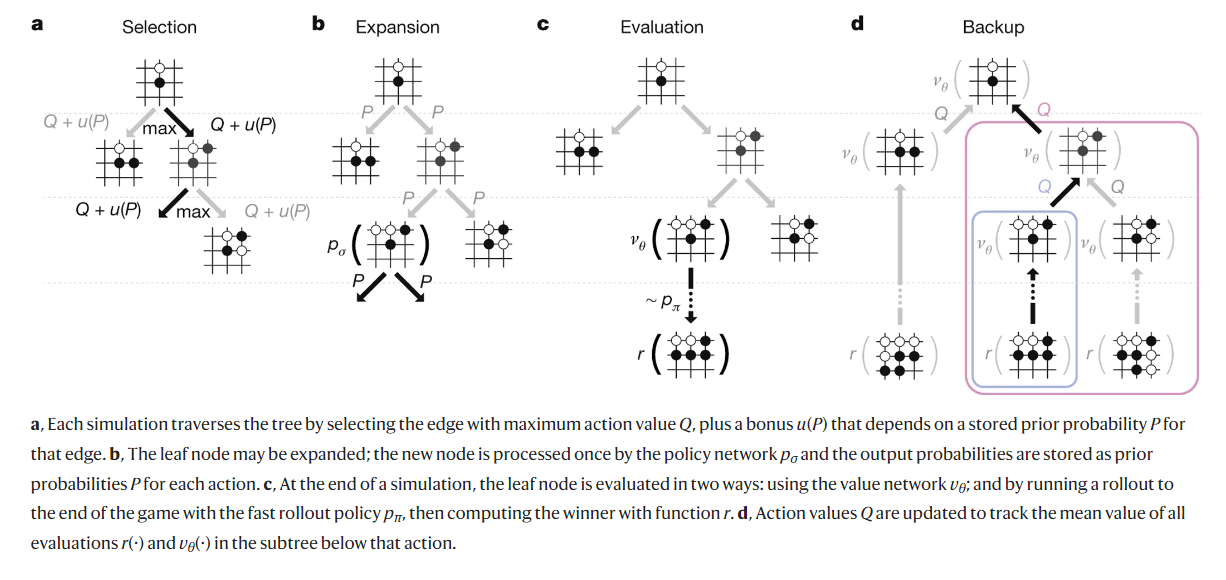

-> to create the tree, the rules of chess have to be programmed

### Current plan

given state s

1. generate all legal moves m
2. for each m run n simulations and calculate a value based on 

### Chess rules

The program needs to be able to know what moves are legal, so the rules of chess have to be programmed.
This requires a move generator function.
This move generator function takes a game state as an input and outputs all posible legal moves

In [1]:
import numpy as np
import random
from copy import deepcopy

In [2]:
pieces = {'empty': 0, 'pawn': 1, 'knight': 2, 'bishop': 3, 'rook': 4, 'queen': 5, 'king': 6, 'en_passant_pawn': 7}
starting_game_state = np.asarray([[4, 2, 3, 5, 6, 3, 2, 4], [1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1], [-4, -2, -3, -6, -5, -3, -2, -4]])
print(starting_game_state)

[[ 4  2  3  5  6  3  2  4]
 [ 1  1  1  1  1  1  1  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-4 -2 -3 -6 -5 -3 -2 -4]]


In [3]:
def perform_move(state, d1, d2, player_turn, piece, t1, t2):
    """
    Perform a legal move
    state: current game state
    d1: first dimension of the piece making the move
    d2: second dimension of the piece making the move
    player_turn: determines whose turn it is
    piece: name of the piece making the move
    t1: first dimension of the target location
    t2: second dimension of the target location
    """
    
    #create a copy of the current state and modify it to reflect the new state after the legal move
    new_state = deepcopy(state)
    new_state[d1, d2] = pieces['empty']
    new_state[t1, t2] = pieces[piece]*player_turn
    
    #return new state after legal move
    return new_state

In [4]:
def evaluate_rook(state, d1, d2, player_turn):
    """
    Evaluate all possible moves a rook could make and return the legal ones
    state: current game state
    d1: first dimension of the rook
    d2: second dimension of the rook
    player_turn: determines whose turn it is
    """
    
    #specify piece
    piece = 'rook'
    
    #initialize legal moves array
    legal_moves = []
    
    #get board shape
    (dim1, dim2) = state.shape
    
    #decreasing dim1
    for i in range(d1 - 1, -1, -1):
        #check if target square is empty (legal move)
        if state[i, d2] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, i, d2))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[i, d2] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, i, d2))
            break
        #if an illegal move is encountered, stop looking
        else:
            break
            
    #increasing dim1
    for i in range(d1 + 1, dim1, 1):
        #check if target square is empty (legal move)
        if state[i, d2] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, i, d2))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[i, d2] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, i, d2))
            break
        #if an illegal move is encountered, stop looking
        else:
            break
            
    #decreasing dim2
    for i in range(d2 - 1, -1, -1):
        #check if target square is empty (legal move)
        if state[d1, i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1, i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1, i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1, i))
            break
        #if an illegal move is encountered, stop looking
        else:
            break
    
    #increasing dim2
    for i in range(d2 + 1, dim2, 1):
        #check if target square is empty (legal move)
        if state[d1, i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1, i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1, i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1, i))
            break
        #if an illegal move is encountered, stop looking
        else:
            break
    
    return legal_moves

In [5]:
def evaluate_knight(state, d1, d2, player_turn):
    """
    Evaluate all possible moves a knight could make and return the legal ones
    state: current game state
    d1: first dimension of the knight
    d2: second dimension of the knight
    player_turn: determines whose turn it is
    """
    
    #specify piece
    piece = 'knight'
    
    #initialize legal moves array
    legal_moves = []
    
    #get board shape
    (dim1, dim2) = state.shape
    
    #iterate over all differences in the original dimensions
    for dd1, dd2 in [(2, 1), (1, 2), (-1, 2), (-2, 1), (-2, -1), (-1, -2), (1, -2), (2, -1)]:
        #check if move doesn't exit the board
        if (0 <= d1 + dd1 < dim1) and (0 <= d2 + dd2 < dim2):
            #check if move is legal (empty square or piece of the opponent)
            if state[d1 + dd1, d2 + dd2] == pieces['empty'] or player_turn*state[d1 + dd1, d2 + dd2] < 0:
                #perform move and add to list of legal moves
                legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + dd1, d2 + dd2))
                
    return legal_moves

In [6]:
def evaluate_bishop(state, d1, d2, player_turn):
    """
    Evaluate all possible moves a bishop could make and return the legal ones
    state: current game state
    d1: first dimension of the bishop
    d2: second dimension of the bishop
    player_turn: determines whose turn it is
    """
    
    #specify piece
    piece = 'bishop'
    
    #initialize legal moves array
    legal_moves = []
    
    #get board shape
    (dim1, dim2) = state.shape
    
    #decreasing dim1, decreasing dim2
    i = -1
    while (d1 + i >= 0) and (d2 + i >= 0):
        #check if target square is empty (legal move)
        if state[d1 + i, d2 + i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 + i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1 + i, d2 + i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 + i))
            break
        else:
            break
        i -= 1
        
    #decreasing dim1, increasing dim2
    i = -1
    while (d1 + i >= 0) and (d2 - i < dim2):
        #check if target square is empty (legal move)
        if state[d1 + i, d2 - i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 - i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1 + i, d2 - i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 - i))
            break
        else:
            break
        i -= 1
        
    #increasing dim1, decreasing dim2
    i = 1
    while (d1 + i < dim1) and (d2 - i >= 0):
        #check if target square is empty (legal move)
        if state[d1 + i, d2 - i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 - i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1 + i, d2 - i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 - i))
            break
        else:
            break
        i += 1
        
    #increasing dim1, increasing dim2
    i = 1
    while (d1 + i < dim1) and (d2 + i < dim2):
        #check if target square is empty (legal move)
        if state[d1 + i, d2 + i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 + i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1 + i, d2 + i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 + i))
            break
        else:
            break
        i += 1
            
    return legal_moves

In [7]:
def evaluate_queen(state, d1, d2, player_turn):
    """
    Evaluate all possible moves a queen could make and return the legal ones
    state: current game state
    d1: first dimension of the queen
    d2: second dimension of the queen
    player_turn: determines whose turn it is
    """
    
    #specify piece
    piece = 'queen'
    
    #initialize legal moves array
    legal_moves = []
    
    #get board shape
    (dim1, dim2) = state.shape
    
    #decreasing dim1
    for i in range(d1 - 1, -1, -1):
        #check if target square is empty (legal move)
        if state[i, d2] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, i, d2))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[i, d2] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, i, d2))
            break
        #if an illegal move is encountered, stop looking
        else:
            break
            
    #increasing dim1
    for i in range(d1 + 1, dim1, 1):
        #check if target square is empty (legal move)
        if state[i, d2] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, i, d2))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[i, d2] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, i, d2))
            break
        #if an illegal move is encountered, stop looking
        else:
            break
            
    #decreasing dim2
    for i in range(d2 - 1, -1, -1):
        #check if target square is empty (legal move)
        if state[d1, i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1, i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1, i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1, i))
            break
        #if an illegal move is encountered, stop looking
        else:
            break
    
    #increasing dim2
    for i in range(d2 + 1, dim2, 1):
        #check if target square is empty (legal move)
        if state[d1, i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1, i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1, i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1, i))
            break
        #if an illegal move is encountered, stop looking
        else:
            break
            
    #decreasing dim1, decreasing dim2
    i = -1
    while (d1 + i >= 0) and (d2 + i >= 0):
        #check if target square is empty (legal move)
        if state[d1 + i, d2 + i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 + i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1 + i, d2 + i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 + i))
            break
        else:
            break
        i -= 1
        
    #decreasing dim1, increasing dim2
    i = -1
    while (d1 + i >= 0) and (d2 - i < dim2):
        #check if target square is empty (legal move)
        if state[d1 + i, d2 - i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 - i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1 + i, d2 - i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 - i))
            break
        else:
            break
        i -= 1
        
    #increasing dim1, decreasing dim2
    i = 1
    while (d1 + i < dim1) and (d2 - i >= 0):
        #check if target square is empty (legal move)
        if state[d1 + i, d2 - i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 - i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1 + i, d2 - i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 - i))
            break
        else:
            break
        i += 1
        
    #increasing dim1, increasing dim2
    i = 1
    while (d1 + i < dim1) and (d2 + i < dim2):
        #check if target square is empty (legal move)
        if state[d1 + i, d2 + i] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 + i))
        #check if target square contains an opponent (legal move, but triggers break)
        elif player_turn*state[d1 + i, d2 + i] < 0:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + i, d2 + i))
            break
        else:
            break
        i += 1
    
    return legal_moves

In [8]:
def evaluate_king(state, d1, d2, player_turn):
    """
    Evaluate all possible moves a king could make and return the legal ones
    state: current game state
    d1: first dimension of the queen
    d2: second dimension of the queen
    player_turn: determines whose turn it is
    """
    
    #specify piece
    piece = 'king'
    
    #initialize legal moves array
    legal_moves = []
    
    #get board shape
    (dim1, dim2) = state.shape
    
    #iterate over all positions in the square around the piece
    for dd1 in range(-1, 2, 1):
        for dd2 in range(-1, 2, 1):
            #check if position is possible (doesn't fall outside the board or is equal to the starting position)
            if 0 <= d1 + dd1 < dim1 and 0 <= d2 + dd2 < dim2 and not (d1 + dd1 == d1 and d2 + dd2 == d2):
                #check if move is legal (empty square or piece of the opponent)
                if state[d1 + dd1, d2 + dd2] == pieces['empty'] or player_turn*state[d1 + dd1, d2 + dd2] < 0:
                    #perform move and add to list of legal moves
                    legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + dd1, d2 + dd2))
                
    return legal_moves

In [9]:
def evaluate_pawn(state, d1, d2, player_turn):
    """
    Evaluate all possible moves a pawn could make and return the legal ones
    state: current game state
    d1: first dimension of the queen
    d2: second dimension of the queen
    player_turn: determines whose turn it is
    """
    
    #specify piece
    piece = 'pawn'
    
    #initialize legal moves array
    legal_moves = []
    
    #get board shape
    (dim1, dim2) = state.shape
    
    #determine starting file
    starting_file = {1: 1, -1: 6}
    
    #not taking pieces (moving straight)
    #check for promotion
    if d1 + player_turn == starting_file[player_turn] + player_turn*6 and state[d1 + player_turn, d2] == pieces['empty']:
        #perform moves and add to list of legal moves
        legal_moves.append(perform_move(state, d1, d2, player_turn, 'queen', d1 + player_turn, d2))
        legal_moves.append(perform_move(state, d1, d2, player_turn, 'rook', d1 + player_turn, d2))
        legal_moves.append(perform_move(state, d1, d2, player_turn, 'bishop', d1 + player_turn, d2))
        legal_moves.append(perform_move(state, d1, d2, player_turn, 'knight', d1 + player_turn, d2))
    #if promotion isn't possible, move piece forward
    elif state[d1 + player_turn, d2] == pieces['empty']:
        #perform move and add to list of legal moves
        legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + player_turn, d2))
        #move two squares forward on first move
        if d1 == starting_file[player_turn] and state[d1 + 2*player_turn, d2] == pieces['empty']:
            #perform move and add to list of legal moves
            legal_moves.append(perform_move(state, d1, d2, player_turn, 'en_passant_pawn', d1 + 2*player_turn, d2))
            
    #taking pieces (moving diagonally)
    #decreasing dim2
    if d2 - 1 >= 0:
        if player_turn*state[d1 + player_turn, d2 - 1] < 0:
            #check for promotion
            if d1 + player_turn == starting_file[player_turn] + player_turn*6:
                #perform moves and add to list of legal moves
                legal_moves.append(perform_move(state, d1, d2, player_turn, 'queen', d1 + player_turn, d2 - 1))
                legal_moves.append(perform_move(state, d1, d2, player_turn, 'rook', d1 + player_turn, d2 - 1))
                legal_moves.append(perform_move(state, d1, d2, player_turn, 'bishop', d1 + player_turn, d2 - 1))
                legal_moves.append(perform_move(state, d1, d2, player_turn, 'knight', d1 + player_turn, d2 - 1))
            else:
                #perform move and add to list of legal moves
                legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + player_turn, d2 - 1))
                
    #increasing dim2
    if d2 + 1 < dim2:
        if player_turn*state[d1 + player_turn, d2 + 1] < 0:
            #check for promotion
            if d1 + player_turn == starting_file[player_turn] + player_turn*6:
                #perform moves and add to list of legal moves
                legal_moves.append(perform_move(state, d1, d2, player_turn, 'queen', d1 + player_turn, d2 + 1))
                legal_moves.append(perform_move(state, d1, d2, player_turn, 'rook', d1 + player_turn, d2 + 1))
                legal_moves.append(perform_move(state, d1, d2, player_turn, 'bishop', d1 + player_turn, d2 + 1))
                legal_moves.append(perform_move(state, d1, d2, player_turn, 'knight', d1 + player_turn, d2 + 1))
            else:
                #perform move and add to list of legal moves
                legal_moves.append(perform_move(state, d1, d2, player_turn, piece, d1 + player_turn, d2 + 1))
                
    #check en passant
    #decreasing dim2
    if d2 - 1 >= 0:
        if player_turn*state[d1 + player_turn, d2 - 1] < 0 and abs(state[d1, d2 - 1]) == pieces['en_passant_pawn']:
            #perform move and add to list of legal moves
            move_state = perform_move(state, d1, d2, player_turn, piece, d1 + player_turn, d2 - 1)
            move_state[d1, d2 - 1] = 0
            legal_moves.append(move_state)
            
    #increasing dim2
    if d2 + 1 < dim2:
        if player_turn*state[d1 + player_turn, d2 + 1] < 0 and abs(state[d1, d2 + 1]) == pieces['en_passant_pawn']:
            #perform move and add to list of legal moves
            move_state = perform_move(state, d1, d2, player_turn, piece, d1 + player_turn, d2 + 1)
            move_state[d1, d2 + 1] = 0
            legal_moves.append(move_state)

    return legal_moves

In [10]:
def move_generator(state, player_turn):
    """
    This function is given a game state and whose turn it is and outputs all possible legal moves
    state: current game state
    player_turn: determines whose turn it is
    legal_moves: array of legal moves
    """
    
    #initialize legal moves array
    legal_moves = []
    
    #get board shape
    (dim1, dim2) = state.shape
    
    legal_len = len(legal_moves)
    
    #change en passant pawns to normal pawns
    for d1 in range(0, dim1, 1):
        for d2 in range(0, dim2, 1):
            if state[d1, d2] == player_turn*pieces['en_passant_pawn']:
                state[d1, d2] = player_turn*pieces['pawn']
    
    
    #iterate over all board positions
    for d1 in range(0, dim1, 1):
        for d2 in range(0, dim2, 1):
            #if piece belongs to current player, evaluate appropriately
            piece = state[d1, d2]
            if player_turn*piece > 0:
                if abs(piece) == pieces['pawn']:
                    legal_moves += evaluate_pawn(state, d1, d2, player_turn)
                elif abs(piece) == pieces['knight']:
                    legal_moves += evaluate_knight(state, d1, d2, player_turn)
                elif abs(piece) == pieces['bishop']:
                    legal_moves += evaluate_bishop(state, d1, d2, player_turn)
                elif abs(piece) == pieces['rook']:
                    legal_moves += evaluate_rook(state, d1, d2, player_turn)
                elif abs(piece) == pieces['queen']:
                    legal_moves += evaluate_queen(state, d1, d2, player_turn)
                elif abs(piece) == pieces['king']:
                    legal_moves += evaluate_king(state, d1, d2, player_turn)
                
    return legal_moves
    

In [11]:
def evaluate_state(state, player_turn):
    """
    Check if the player has won, lost, drawn or if the game continues
    state: current game state
    player_turn: determines whose turn it is
    """
    
    state_evaluation = 0
    
    #check if king is still present
    if player_turn*pieces['king'] not in state.flatten():
        state_evaluation = -1
    #check if opponents king is still present
    elif -1*player_turn*pieces['king'] not in state.flatten():
        state_evaluation = 1
    
    return state_evaluation

In [12]:
player_turn = 1
state = starting_game_state
while evaluate_state(state, player_turn) == 0:
    moves = move_generator(state, player_turn)
    #print(moves)
    random_move = random.randint(0, len(moves) - 1)
    state = moves[random_move]
    #print(state)
    player_turn *= -1

### Classical Monte Carlo Tree Search

apply a value to each node using the upper confidence bound one applied to trees (UCT).

UCT for a state $S_i$: 
$UCT(S_i) = w_i/n_i + c*sqrt(ln(N_i)/n_i$

with $w_i$: the amount of wins
$n_i$: the amount of visits
$c$: exploration parameter
$N_i$: the amount of visists of the parent node

$w_i/n_i$ is the exploitation part

$c*sqrt(ln(N_i)/n_i$ is the exploration part

punish many iterations through the same nodes to encourage a more diverse exploration of the underlying nodes of a given state

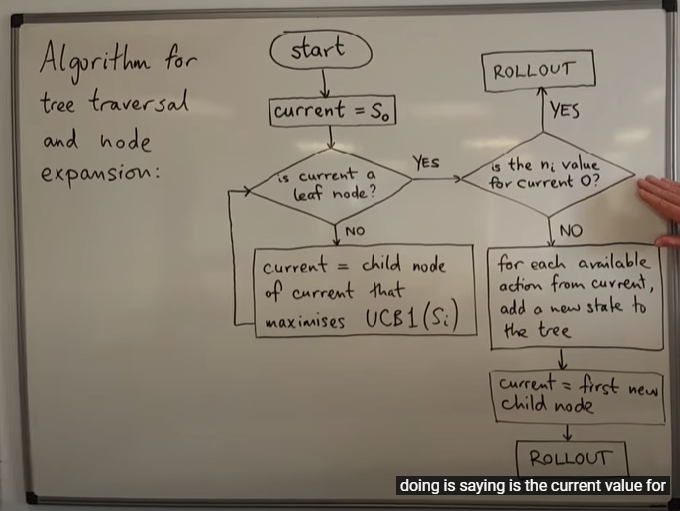
https://www.youtube.com/watch?v=UXW2yZndl7U&t=771s

My current game state is the first current state
1. calculate all possible moves from the current state
2. UCT will be infinite for all possible moves since none will have been visited yet
3. so we'll have to do a rollout for each leaf node (every possible move is a leaf node)
    - a rollout consists of doing random actions starting from the leaf node to a terminal state
    - a terminal state has a value (win or lose in chess)
3. add terminal value to the value of the initial leaf node (which had value 0 to start) and the initial state (also had value 0 to start)
4. recalculate UCT for all leaf nodes 

In [13]:
class TreeNode:
    def __init__(self, state, q_value, visits, UCT, player_turn, parent = None):
        self.state = state
        self.q_value = q_value
        self.visits = visits
        self.UCT = UCT
        self.player_turn = player_turn
        self.children = []
        self.parent = parent
        
    def add_child(self, child_node):
        self.children.append(child_node)
        child_node.parent = self
        
    def update_node(self, q_value):
        self.q_value += q_value
        self.visits += 1
        if self.parent != None:
            self.parent.update_node(q_value)
            self.UCT = calculate_UCT(self.q_value, self.visits, self.parent.visits)

In [14]:
def calculate_UCT(q_value, visits, parent_visits):
    return q_value/visits + 2*np.sqrt(np.log(visits)/parent_visits)

In [18]:
def player_MCTS(state):
    
    player_turn = 1
    
    init_value = 0
    init_visits = 0
    init_UCT = float('inf')

    root = TreeNode(state, init_value, init_visits, init_UCT, player_turn)

    for i in range(1000):
        #print(i)
        #always start at the root
        current_node = root

        #check if current node is leaf node
        while len(current_node.children) != 0:
            UCT = -float('inf')
            for child in current_node.children:
                if child.UCT > UCT:
                    current_node = child
                    UCT = child.UCT

        #check amount of visits
        #no visits, do a rollout
        if current_node.visits == 0:
            #print('rollout')
            rollout_player_turn = current_node.player_turn
            state = current_node.state
            q_value = 0
            rollout_length = 0
            while q_value == 0:
                moves = move_generator(state, rollout_player_turn)
                random_move = random.randint(0, len(moves) - 1)
                state = moves[random_move]
                q_value = evaluate_state(state, player_turn)
                rollout_player_turn = -1*rollout_player_turn
                rollout_length += 1
            #update leaf and all parent nodes
            #print('update')
            current_node.update_node(q_value)
        #if there are visits, expand
        else:
            #print('expand')
            for move in move_generator(current_node.state, current_node.player_turn):
                #add all possible moves as leaves to the root
                child = TreeNode(move, 0, 0, float('inf'), -1*current_node.player_turn)
                current_node.add_child(child)

    max_UCT = -float('inf')
    for child in root.children:
        if child.UCT > max_UCT:
            final_move = child.state
            max_UCT = child.UCT
            
    return final_move

    

In [26]:
def player_heuristic(state):
    
    """
    current heuristics:
    evaluate rollout by the player whose node is being rolled out, so the opponent is no longer assumed to take the worst option
    """
    
    player_turn = -1

    init_value = 0
    init_visits = 0
    init_UCT = float('inf')

    root = TreeNode(state, init_value, init_visits, init_UCT, player_turn)

    for i in range(1000):
        #print(i)
        #always start at the root
        current_node = root

        #check if current node is leaf node
        while len(current_node.children) != 0:
            UCT = -float('inf')
            for child in current_node.children:
                if child.UCT > UCT:
                    current_node = child
                    UCT = child.UCT

        #check amount of visits
        #no visits, do a rollout
        if current_node.visits == 0:
            #print('rollout')
            rollout_player_turn = current_node.player_turn
            state = current_node.state
            q_value = 0
            rollout_length = 0
            while q_value == 0:
                moves = move_generator(state, rollout_player_turn)
                random_move = random.randint(0, len(moves) - 1)
                state = moves[random_move]
                q_value = evaluate_state(state, current_node.player_turn)           #############################
                rollout_player_turn = -1*rollout_player_turn
                rollout_length += 1
            #update leaf and all parent nodes
            #print('update')
            current_node.update_node(q_value*current_node.player_turn*player_turn)                   ######################
        #if there are visits, expand
        else:
            #print('expand')
            for move in move_generator(current_node.state, current_node.player_turn):
                #add all possible moves as leaves to the root              
                #if a child leads to victory or loss, always choose that child
                init_value = 0
                child_moves = move_generator(move, -1*current_node.player_turn)
                for child_move in child_moves:
                    if evaluate_state(child_move, player_turn) == -1:
                        init_value += -1000
                init_value += evaluate_state(move, current_node.player_turn)
                child = TreeNode(move, init_value, 0, float('inf'), -1*current_node.player_turn)
                current_node.add_child(child)

    max_UCT = -float('inf')
    for child in root.children:
        if child.UCT > max_UCT:
            final_move = child.state
            max_UCT = child.UCT
            
    return final_move

In [27]:
state = starting_game_state
outcomes = []
for i in range(10):
    go = 0
    state = starting_game_state
    while go == 0:
        state = player_MCTS(state)
        go = 1*evaluate_state(state, 1)
        if evaluate_state(state, 1) == 1:
            print("1 wins")
            print(state)
        if go != 0:
            break
        state = player_heuristic(state)
        go = -1*evaluate_state(state, -1)
        if evaluate_state(state, -1) == 1:
            print("-1 wins")
            print(state)
        if go != 0:
            break
        print(state)
    outcomes.append(go)
    
    

[[ 4  2  3  5  6  3  2  4]
 [ 1  0  1  1  1  1  1  1]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0 -2  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-4  0 -3 -6 -5 -3 -2 -4]]
[[ 4  2  3  5  6  3  2  4]
 [ 1  0  0  1  1  1  1  1]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1 -2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-4  0 -3 -6 -5 -3 -2 -4]]
[[ 4  2  3  5  6  3  0  4]
 [ 1  0  0  1  1  1  1  1]
 [ 0  1  0  0  0  2  0  0]
 [ 0  0  1 -2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [-1 -1 -1  0 -1 -1 -1 -1]
 [-4  0 -3 -6 -5 -3 -2 -4]]
[[ 4  2  3  5  6  3  0  4]
 [ 1  0  0  1  1  1  1  1]
 [ 0  0  0  0  0  2  0  0]
 [ 0  1  1 -2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0 -1  0]
 [-1 -1 -1  0 -1 -1  0 -1]
 [-4  0 -3 -6 -5 -3 -2 -4]]
[[ 4  2  3  0  6  3  0  4]
 [ 1  0  0  1  1  1  1  1]
 [ 0  5  0  0  0  2  0  0]
 [ 0  1  1 -2  0  0  0  0]
 [ 0  0  0 -1  0  0  0  

In [20]:
print(outcomes)

[1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1]


In [21]:
print(sum(outcomes))

2


In [ ]:
#implement draw?? (does alphazero have it?)
#implement check for check (so no illegal moves can be made at that point)?? (model seems to be too stupid to understand this)

In [ ]:
#properly test it against another model
#implement heuristics
#start thinking about deep learning modifications